In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys

In [2]:
from utils_custom import *

## Execute the analysis

In [3]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added/output'
tf_pairs_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/combinatorial_control/SLIDE_LF_enriched_pair_GC-1_PB-2.csv'
#standalone_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
#interacting_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(data_file)

In [5]:
# Define the transcription factors
tf_list = ['BACH2', 'BATF', 'IRF4', 'PRDM1']
# Get the TF indices
tf_indices, gene_indices = get_tf_indices(dictys_dynamic_object, tf_list)
print(f"TF indices: {tf_indices}")
print(f"Gene indices: {gene_indices}")

TF indices: [9, 10, 97, 172]
Gene indices: [978, 997, 5093, 8469]


#### Windows

In [6]:
# Assign window indices for each branch between 0 to 60
pb_window_indices = list(range(30, 46)) + [2]
#abc_window_indices = [1] + list(range(4, 30)) + [0]
gc_window_indices = list(range(46, 61)) + [3]

In [7]:
display(pb_window_indices)
display(gc_window_indices)

[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 2]

[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 3]

#### Trying dictys custom function

In [8]:
regulations = []
for tf in tf_list:
    for target in tf_list:  # Using TFs as targets to show cross-regulation
        regulations.append((tf, target))

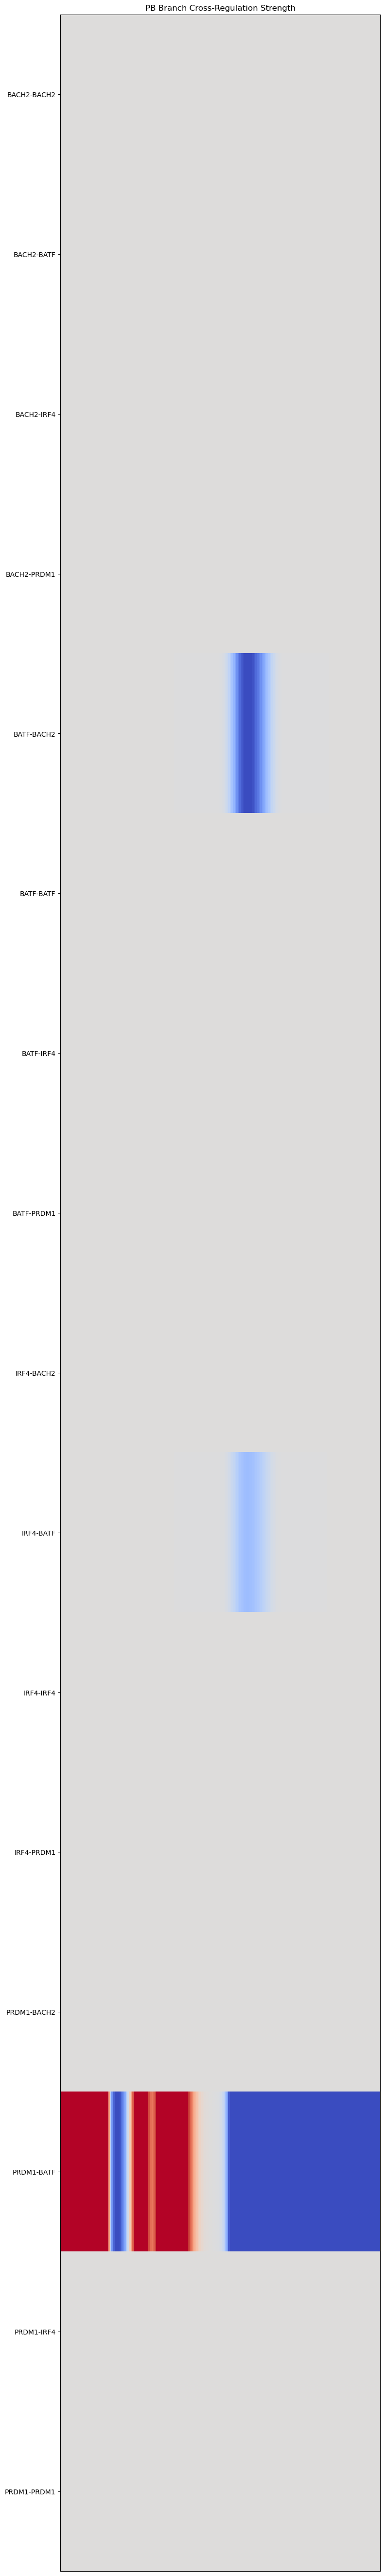

In [10]:
# Plot for PB branch (including ACtB cells)
fig_pb, ax_pb, cmap_pb = dictys.plot.dynamic.fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,  # First window index for PB branch
    stop=2,  # Last window index for PB branch
    regulations=regulations,
    num=300,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    figsize=(8, 4),  # Adjust figure size as needed
    cmap=colors.LinearSegmentedColormap.from_list('custom', ['red', 'white', 'green'])  # Use green for positive and red for negative values
)
plt.title('PB Branch Cross-Regulation Strength')
plt.tight_layout()
plt.show()

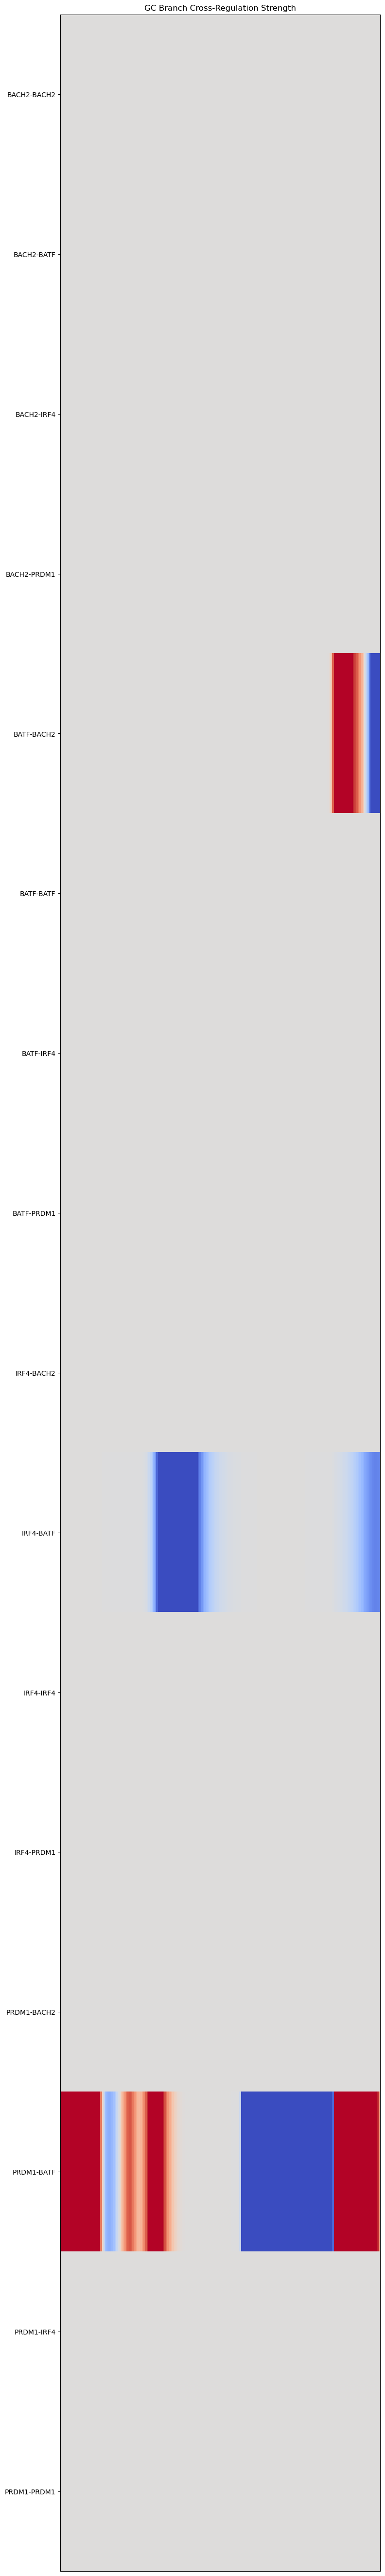

In [9]:
# Plot for GC branch (excluding ACtB cells)
fig_gc, ax_gc, cmap_gc = dictys.plot.dynamic.fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,  # First window index for PB branch
    stop=3,  # Last window index for PB branch
    regulations=regulations,
    num=200,  # Number of points to interpolate
    dist=0.0001,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    figsize=(8, 4),  # Adjust figure size as needed
    cmap='coolwarm'  # Use diverging colormap for positive/negative regulation
)
plt.title('GC Branch Cross-Regulation Strength')
plt.tight_layout()
plt.show()

### Combinatorial Control

In [8]:
# get TF pairs from combinatorial control
tf_pairs_df = pd.read_csv(tf_pairs_file)
tf_pairs_and_targets = tf_pairs_df[['TF', 'common']]
display(tf_pairs_and_targets)

,TF,common
0,"('AFF1', 'IRF4')","{'PRDM1', 'AFF3', 'ANKRD28', 'ELL2', 'HSP90B1'}"
1,"('ATF5', 'CREB3L2')","{'FNDC3B', 'SEL1L3', 'BTG2', 'SLAMF7', 'ARFGAP..."
2,"('BACH2', 'EBF1')","{'JCHAIN', 'XBP1', 'MZB1'}"
3,"('BACH2', 'FLI1')","{'JCHAIN', 'XBP1', 'MZB1'}"
4,"('BACH2', 'FOSB')","{'JCHAIN', 'XBP1', 'MZB1'}"
...,...,...
145,"('XBP1', 'IRF4')","{'TXNDC11', 'FNDC3B', 'PRDM1', 'AFF3', 'JCHAIN..."
146,"('XBP1', 'TAF3')","{'HSP90B1', 'FNDC3B', 'TXNDC5'}"
147,"('ZBTB16', 'IRF4')","{'AFF3', 'HSP90B1'}"
148,"('ZBTB16', 'XBP1')","{'JCHAIN', 'HSP90B1'}"


In [9]:
all_tfs = []
for pair_str in tf_pairs_and_targets['TF']:
    tf1, tf2 = eval(pair_str)  # Convert string representation to actual tuple
    all_tfs.extend([tf1, tf2])  # Add both TFs to the list

# Get unique TFs using set
unique_tfs = sorted(set(all_tfs))

print(f"Number of unique TFs: {len(unique_tfs)}")
print("Unique TFs:", unique_tfs)

Number of unique TFs: 75
Unique TFs: ['AFF1', 'ARID5B', 'ATF5', 'BACH2', 'BATF3', 'BCL11A', 'BCL6', 'BHLHE22', 'BHLHE41', 'CHD1', 'CREB3L2', 'EBF1', 'EGR1', 'ESR1', 'FLI1', 'FOSB', 'FOSL1', 'FOXO1', 'HBP1', 'HERPUD1', 'HIVEP1', 'HIVEP2', 'HIVEP3', 'ID2', 'IKZF1', 'IRF4', 'IRF8', 'JUN', 'JUNB', 'KLF2', 'KLF4', 'L3MBTL4', 'MEF2A', 'MEF2C', 'NFATC2', 'NFKB1', 'NR6A1', 'NRF1', 'PAX5', 'PBX3', 'PBX4', 'PHF21A', 'PLAG1', 'PLAGL1', 'POLR2A', 'POU3F1', 'PRDM1', 'PTEN', 'REL', 'RFX3', 'RREB1', 'RUNX1', 'RUNX2', 'SMAD3', 'SOX4', 'SP3', 'STAT1', 'STAT4', 'TAF1', 'TAF3', 'TCF12', 'TCF4', 'TCFL5', 'TET3', 'TFDP2', 'TFEB', 'TFEC', 'TGIF1', 'XBP1', 'ZBTB16', 'ZBTB7A', 'ZFHX3', 'ZNF318', 'ZNF506', 'ZNF652']


#### Filtering TF-Target pairs based on regulation strength

In [6]:
def create_tf_target_pairs(dictys_dynamic_object, tf_pairs_df):
    """
    Create a list of TF-Target tuples from combinatorial control data,
    checking presence of both TFs and targets in the dynamic object.
    
    Parameters:
    -----------
    dictys_dynamic_object : dictys.net.dynamic_network
        The dynamic network object containing the regulatory network data
    tf_pairs_df : pandas.DataFrame
        DataFrame containing TF pairs and their common targets
        Columns: ['TF' (string tuple), 'common' (string set)]
        
    Returns:
    --------
    list
        List of (regulator, target) tuples where both are present in dynamic object
    """
    tf_target_pairs = []
    
    for _, row in tf_pairs_df.iterrows():
        # Get TF pair and targets
        tf1, tf2 = eval(row['TF'])
        common_targets = eval(row['common'])
        
        # Check if TFs are present in dynamic object
        present_tfs = check_tf_presence(dictys_dynamic_object, [tf1, tf2])
        
        # Check if targets are present in dynamic object
        present_targets = check_gene_presence(dictys_dynamic_object, common_targets)
        
        # Create pairs for present TFs and targets
        for tf in present_tfs:
            for target in present_targets:
                tf_target_pairs.append((tf, target))
    
    # Remove any duplicates
    tf_target_pairs = list(set(tf_target_pairs))
    
    print(f"Created {len(tf_target_pairs)} unique TF-target pairs")
    return tf_target_pairs

In [10]:
cc_tf_target_pairs = create_tf_target_pairs(dictys_dynamic_object, tf_pairs_and_targets)
display(cc_tf_target_pairs)

Created 196 unique TF-target pairs


[('MEF2A', 'SEL1L3'),
 ('REL', 'HSP90B1'),
 ('SMAD3', 'RUNX2'),
 ('TGIF1', 'MZB1'),
 ('XBP1', 'HSP90B1'),
 ('IRF4', 'MZB1'),
 ('TGIF1', 'TRAM1'),
 ('RREB1', 'RUNX2'),
 ('BCL6', 'HSP90B1'),
 ('NFKB1', 'FNDC3B'),
 ('FOSL1', 'JCHAIN'),
 ('TAF1', 'TXNDC5'),
 ('XBP1', 'PRDM1'),
 ('PLAG1', 'BTG2'),
 ('XBP1', 'JCHAIN'),
 ('BACH2', 'HSP90B1'),
 ('NFKB1', 'IRF4'),
 ('SMAD3', 'XBP1'),
 ('NRF1', 'TXNDC11'),
 ('TFEB', 'PAX5'),
 ('KLF4', 'AFF3'),
 ('BACH2', 'PRDM1'),
 ('BACH2', 'JCHAIN'),
 ('RREB1', 'PAX5'),
 ('HBP1', 'HSP90B1'),
 ('IRF8', 'BTG2'),
 ('FLI1', 'JCHAIN'),
 ('REL', 'AFF3'),
 ('IRF4', 'ELL2'),
 ('XBP1', 'FNDC3B'),
 ('REL', 'IRF4'),
 ('SP3', 'HSP90B1'),
 ('MEF2A', 'JCHAIN'),
 ('EGR1', 'FNDC3B'),
 ('HBP1', 'JCHAIN'),
 ('PLAG1', 'SEL1L3'),
 ('ESR1', 'AFF3'),
 ('RUNX1', 'JCHAIN'),
 ('IRF8', 'IRF4'),
 ('JUN', 'IRF4'),
 ('BACH2', 'FNDC3B'),
 ('RUNX2', 'GLCCI1'),
 ('STAT4', 'TXNDC5'),
 ('PAX5', 'AFF3'),
 ('MEF2C', 'IRF4'),
 ('STAT1', 'JCHAIN'),
 ('FOSB', 'MZB1'),
 ('RFX3', 'TXNDC5'),
 ('STAT1'

In [ ]:
# get weights across windows 

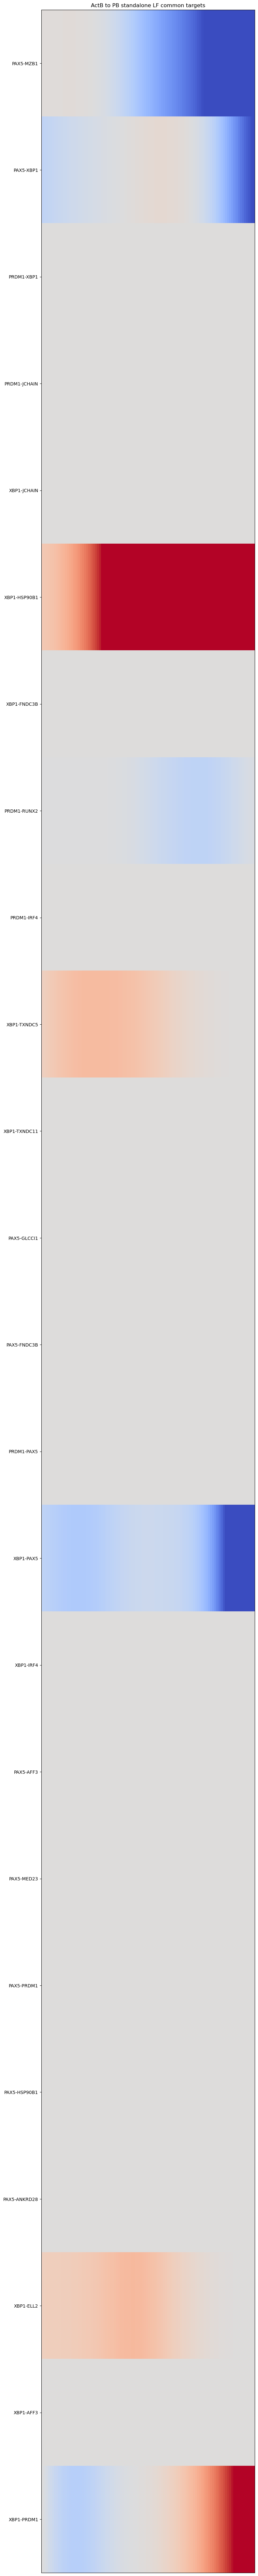

In [25]:
# Plot for PB branch (including ACtB cells)
fig_pb, ax_pb, cmap_pb = dictys.plot.dynamic.fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=1,  # First window index for PB branch
    stop=2,  # Last window index for PB branch
    regulations=filtered_tf_target_pairs,
    num=100,  # Number of points to interpolate
    dist=0.0005,  # Gaussian kernel smoothing distance/length scale between cells. Larger value means stronger smoothing.
    figsize=(8, 4),  # Adjust figure size as needed
    cmap='coolwarm'  # Use diverging colormap for positive/negative regulation
)
plt.title('ActB to PB standalone LF common targets')
plt.tight_layout()
plt.show()